In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import root
from scipy.stats import norm, t
from arelle import Cntlr
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
from matplotlib.ticker import FormatStrFormatter
import matplotlib.dates as mdates
import datetime
formatter = mdates.DateFormatter("%Y-%m-%d")

import eikon as ek
ek.set_app_key('56a14168fc9a480a98de60ed08c0fa8a36fe3860')

In [125]:
#Importar base de datos con precios de acciones
# df_acciones = pd.read_csv('C:/Users/andrgome/ACCIONES/ACCIONES_COL.csv',encoding='latin-1', parse_dates=['Fecha'],dayfirst=True)
# df_mkt_cap = pd.read_csv('C:/Users/andrgome/ACCIONES/CapitalizacionBVC.csv',encoding='latin-1')

emisor = 'CON.CN'

start_date = "2000-12-12" 
end_date = "2021-2-19"

ts,e = ek.get_data('CON.CN',
                   ["TR.PriceClose.date","TR.PriceClose","TR.Volume","TR.CompanyMarketCap"],
                       {'SDate':start_date,'EDate':end_date})

In [195]:
#Diccionario con el nombre de las empresa y sus correspondientes datos como por ejemplo: 
#a) el nombre del archivo xbrl con los estados financieros, b)Calificación del emisor, c) Nombre del emisor en la base de datos de acciones

CORPORATIVO = {"CONDOR-20200930":["0052481694_0056_000008_0000_000000_000000_I-I_2020-09-30.xbrl","2020-10-01","2020-07-01","A-",datetime.date(2020,10,1)],            
            "CONDOR-20200630":["0052386997_0056_000008_0000_000000_000000_I-I_2020-06-30.xbrl","2020-07-01","2020-04-01","A-",datetime.date(2020,7,1)],
           "CONDOR-20200331":["0052293704_0056_000008_0000_000000_000000_I-I_2020-03-31.xbrl","2020-04-01","2020-01-01","A-",datetime.date(2020,4,1)],           
           "CONDOR-20191231":["0052218690_0056_000008_0000_000000_000000_I-C_2019-12-31.xbrl","2020-01-01","2019-10-01","A-",datetime.date(2020,1,1)],
              "CONDOR-20190930":["0052116676_0056_000008_0000_000000_000000_I-I_2019-09-30.xbrl","2019-10-01","2019-07-01","A-",datetime.date(2019,10,1)],
              "CONDOR-20190630":["0052034262_0056_000008_0000_000000_000000_I-I_2019-06-30.xbrl","2019-07-01","2019-04-01","A-",datetime.date(2019,7,1)],
              "CONDOR-20190331":["0051944135_0056_000008_0000_000000_000000_I-I_2019-03-31.xbrl","2019-04-01","2019-01-01","AA-",datetime.date(2019,4,1)],
              "CONDOR-20181231":["0051873476_0056_000008_0000_000000_000000_I-C_2018-12-31.xbrl","2019-01-01","2018-10-01","AA-",datetime.date(2019,1,1)],
              "CONDOR-20180930":["0051769563_0056_000008_0000_000000_000000_I-I_2018-09-30.xbrl","2018-10-01","2018-07-01","AA-",datetime.date(2018,10,1)],
              "CONDOR-20180630":["0051685530_0056_000008_0000_000000_000000_I-I_2018-06-30.xbrl","2018-07-01","2018-04-01","AA-",datetime.date(2018,7,1)],
              "CONDOR-20180331":["0051599759_0056_000008_0000_000000_000000_I-I_2018-03-31.xbrl","2018-04-01","2018-01-01","AA-",datetime.date(2018,4,1)],
              "CONDOR-20171231":["0051522421_0056_000008_0000_000000_000000_I-C_2017-12-31.xbrl","2018-01-01","2017-10-01","AA-",datetime.date(2018,1,1)],
              "CONDOR-20170930":["0051422020_0056_000008_0000_000000_000000_I-I_2017-09-30.xbrl","2017-10-01","2017-07-01","AA-",datetime.date(2017,10,1)],
              "CONDOR-20170630":["0051430929_0056_000008_0000_000000_000000_I-I_2017-06-30.xbrl","2017-07-01","2017-04-01","AA-",datetime.date(2017,7,1)],
              "CONDOR-20170331":["0051429073_0056_000008_0000_000000_000000_I-I_2017-03-31.xbrl","2017-04-01","2017-01-01","AA-",datetime.date(2017,4,1)],
              "CONDOR-20161231":["0051191495_0056_000008_0000_000000_000000_I-C_2016-12-31.xbrl","2017-01-01","2016-10-01","AA-",datetime.date(2017,1,1)]}



#Crear dataframe para almacenar datos de las empresas
datos_empresas = pd.DataFrame().T

#Iteramos para todos los elementos en el diccionario
for key in CORPORATIVO:
    
    EEFF_EMPRESA = CORPORATIVO[key][0]
    
    #Importamos archivo xbrl
    xbrl = Cntlr.Cntlr().modelManager.load(r'C:/Users/andrgome/DEUDA PRIVADA/Emisores/2021 Condor/EEFF/'+EEFF_EMPRESA)

        
    #Lo convertimos a un dataframe
    factData=pd.DataFrame(data=[(fact.concept.qname,
                               fact.value,
                               fact.isNumeric,
                               fact.contextID,
                               fact.context.isStartEndPeriod,
                               fact.context.isInstantPeriod,
                               fact.context.isForeverPeriod,
                               fact.context.startDatetime,
                               fact.context.endDatetime,
                               fact.unitID) for fact in xbrl.facts])

    #Volvemos texto la columna cero
    factData['Nombre'] = factData.apply(lambda row: str(row[0]),axis=1)
    #Volvemos numérica la columna 1
    factData[1] = pd.to_numeric(factData[1],errors='coerce')
    #Extraemos datos financieros
    #Pasivo corriente 
    Pasivo_corriente = factData[(factData['Nombre']=="ifrs:CurrentLiabilities")&(factData[3]=="_ctx1")|
                        (factData['Nombre']=="ifrs:CurrentLiabilities")&(factData[3]=="CierreTrimestreActual")|
                        (factData['Nombre']=="ifrs:CurrentLiabilities")&(factData[8]==pd.to_datetime(CORPORATIVO[key][1]))][1].values[0]/1000
    #Pasivo no corriente 
    Pasivo_no_corriente = factData[(factData['Nombre']=="ifrs:NoncurrentLiabilities")&(factData[3]=="_ctx1")|
                        (factData['Nombre']=="ifrs:NoncurrentLiabilities")&(factData[3]=="CierreTrimestreActual")|
                        (factData['Nombre']=="ifrs:NoncurrentLiabilities")&(factData[8]==pd.to_datetime(CORPORATIVO[key][1]))][1].values[0]/1000
    
        
    #Cálculo volatilidad realizada
    df_acciones = ts.loc[ts['Volume'] != 0]
    df_acciones['Date'] = pd.to_datetime(df_acciones['Date']).dt.date
    df_acciones['Price Close'] = df_acciones['Price Close'].astype(float)
    df_acciones=df_acciones.loc[df_acciones['Date']<CORPORATIVO[key][4]]
    df_vol = pd.DataFrame()
    df_vol['Retorno_diario'] = df_acciones['Price Close'][1:].values/df_acciones['Price Close'][:-1]-1
    df_vol.dropna(axis=0,inplace=True)
    df_vol['volatilidad']=df_vol['Retorno_diario'].rolling(window=252).std()*252**0.5
    Vol_equity = df_vol['volatilidad'].iloc[-1]

    #Buscar la fecha más cercana a la de los EEFF y sacar el market cap en esa fecha
    lista_fechas =df_acciones['Date'].to_list() #Convertir todas las fechas a una lista
    idx = pd.Index(lista_fechas)  #Convertir esta lista a un índice
    posicion= idx.get_loc(CORPORATIVO[key][4], method ='ffill')   #Encontrar la posición del índice más cercana a la fecha  
    
    Market_cap = df_acciones.loc[df_acciones['Date']==df_acciones['Date'].iloc[posicion]]['Company Market Cap'].iloc[-1]/1000000
    
    Activo_inicial = Market_cap + Pasivo_corriente + Pasivo_no_corriente
    Activo = Activo_inicial
    Pasivo = Pasivo_corriente + Pasivo_no_corriente
    Vol_activo_inicial = Vol_equity
    Vol_activo = Vol_activo_inicial
    Equity = Market_cap
    r = 0.0175
    T = 1
    epsilon = 1

    d1 = (np.log(Activo/Pasivo)+(r+0.5*Vol_activo**2)*T)/(Vol_activo*T**0.5)
    d2 = (np.log(Activo/Pasivo)+(r-0.5*Vol_activo**2)*T)/(Vol_activo*T**0.5)

    def function1(x):
        return x - Activo*norm.cdf(d1) + np.exp(-r*T)*norm.cdf(d2)

    def function2(x):
        return Vol_equity - norm.cdf(d1)*(Activo/Equity)*x


    while epsilon > 0.00001:
        sol2 = root(function2,Vol_activo)
        sol1 = root(function1,Activo)

        Equity = sol1.x[0]
        Vol_activo_nueva = sol2.x[0]
        epsilon = Vol_activo_nueva - Vol_activo
        Vol_activo = Vol_activo_nueva
   
    #Crear una lista y agregar características de las empresas
    lista_caracteristicas = []
    lista_caracteristicas.append(key)
    lista_caracteristicas.append(Activo)
    lista_caracteristicas.append(Pasivo)
    lista_caracteristicas.append(Pasivo_corriente)
    lista_caracteristicas.append(Pasivo_no_corriente)    
    lista_caracteristicas.append(Vol_equity)
    lista_caracteristicas.append(Vol_activo)
    lista_caracteristicas.append(Market_cap)
    lista_caracteristicas.append(d1)
    lista_caracteristicas.append(d2)  
    lista_caracteristicas.append(emisor)  
    lista_caracteristicas.append(t.cdf(-d2,5))  #Segundo parámetro son los grados de libertad de la t-student. Entre más alto este número más parecido a una dist normal
    lista_caracteristicas.append(CORPORATIVO[key][3])
    lista_caracteristicas.append(CORPORATIVO[key][1])
    
    
    datos_empresas = datos_empresas.append(pd.DataFrame(lista_caracteristicas).T)

    
datos_empresas = datos_empresas.rename(columns={0:'Empresa y Fecha',
                                                1:'Activo',
                                                2:'Pasivo',
                                                3:'Pasivo_corriente',
                                                4:'Pasivo_no_corriente',
                                                5:'Vol_equity',
                                                6:'Vol_activo',
                                                7:'Market_cap',
                                                8:'d1',
                                                9:'d2',
                                                10:'emisor',
                                                11: 'ProbIncump',
                                                12: 'Calificación',
                                                13: 'Fecha EEFF'
                                               })


#Agregar campo de escala númerica de calificación
conditions = [
    (datos_empresas['Calificación'] == 'AAA'),
    (datos_empresas['Calificación'] == 'AA+'),
    (datos_empresas['Calificación'] == 'AA'),
    (datos_empresas['Calificación'] == 'AA-'),
    (datos_empresas['Calificación'] == 'A+'),
    (datos_empresas['Calificación'] == 'A'),
    (datos_empresas['Calificación'] == 'A-'),
    (datos_empresas['Calificación'] == 'BBB+'),
    (datos_empresas['Calificación'] == 'BBB'),
    (datos_empresas['Calificación'] == 'BBB-')
]  
     
choices = [1,2,3,4,5,6,7,8,9,10]
datos_empresas['Escala_calif'] = np.select(conditions, choices, default='null')
datos_empresas['Escala_calif'] = datos_empresas['Escala_calif'].astype(int)

C:\Users\andrgome\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\andrgome\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\andrgome\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

C:\Users\andrgome\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\andrgome\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\andrgome\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [196]:
datos_empresas

,Empresa y Fecha,Activo,Pasivo,Pasivo_corriente,Pasivo_no_corriente,Vol_equity,Vol_activo,Market_cap,d1,d2,emisor,ProbIncump,Calificación,Fecha EEFF,Escala_calif
0,CONDOR-20200930,1720379.1015,1131654.136,552248.36,579405.776,0.373765,0.140217,588724.9655,1.354365,0.9806,CON.CN,0.185912,A-,2020-10-01,7
0,CONDOR-20200630,1610095.01058,1082252.822,523495.565,558757.257,0.36881,0.13364,527842.18858,1.308963,0.940153,CON.CN,0.195152,A-,2020-07-01,7
0,CONDOR-20200331,1862446.0834,1161719.783,600218.84,561500.943,0.321843,0.126969,700726.3004,1.681814,1.35997,CON.CN,0.115973,A-,2020-04-01,7
0,CONDOR-20191231,1917117.7053,1161826.652,631556.036,530270.616,0.317636,0.129904,755291.0533,1.790652,1.473016,CON.CN,0.100369,A-,2020-01-01,7
0,CONDOR-20190930,1873934.0287,1193310.532,810921.093,382389.439,0.325117,0.124864,680623.4967,1.604527,1.27941,CON.CN,0.128453,A-,2019-10-01,7
0,CONDOR-20190630,2121122.3822,1397421.449,922361.518,475059.931,0.323488,0.118175,723700.9332,1.505893,1.182405,CON.CN,0.145102,A-,2019-07-01,7
0,CONDOR-20190331,2130042.5509,1414957.105,1097284.812,317672.293,0.322168,0.116143,715085.4459,1.485059,1.16289,CON.CN,0.148676,AA-,2019-04-01,4
0,CONDOR-20181231,1914244.102864,1287846.671,1023668.455,264178.216,0.283797,0.098249,626397.431864,1.600163,1.316366,CON.CN,0.122581,AA-,2019-01-01,4
0,CONDOR-20180930,1885332.1423,1273632.544,1039736.156,233896.388,0.260648,0.088492,611699.5983,1.702293,1.441645,CON.CN,0.104486,AA-,2018-10-01,4
0,CONDOR-20180630,1835336.0268,1209277.283,968631.047,240646.236,0.259141,0.091638,626058.7438,1.807056,1.547915,CON.CN,0.09116,AA-,2018-07-01,4


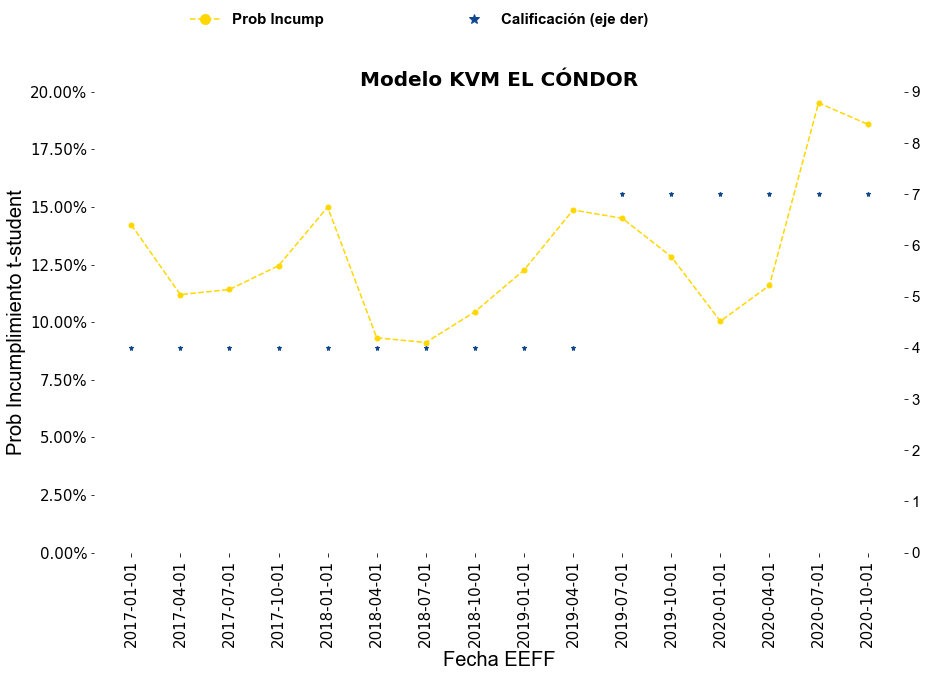

In [236]:
fig = plt.figure()
ax1 = plt.subplot(111,frameon=False)

datos_empresas.sort_values('Fecha EEFF',ascending=True,inplace=True)
font = font_manager.FontProperties(family='Arial',weight='bold', style='normal', size=15)

ax1.plot(datos_empresas['Fecha EEFF'],datos_empresas['ProbIncump']*100,marker='o', linestyle='dashed',color='gold',label='Prob Incump',markersize=5)
ax1.legend(frameon=False,prop=font,loc=1, bbox_to_anchor=(0.3, 1.2),ncol=10,markerscale=2)
ax1.set_xlabel('Fecha EEFF',fontname = "Arial", fontsize=20,color='black')
ax1.set_ylabel('Prob Incumplimiento t-student',fontname = "Arial", fontsize=20,color='black')
ax1.tick_params(axis='y', color = 'black', labelcolor='black')
ax1.yaxis.set_major_formatter(FormatStrFormatter('%2.2f%%'))
ax1.tick_params(axis="x", labelsize=15)
ax1.tick_params(axis="y", labelsize=15)
ax1.axis([None, None, 0, 20])
plt.xticks(rotation=90)

ax2 = ax1.twinx()
ax2.plot(datos_empresas['Fecha EEFF'],datos_empresas['Escala_calif'],marker='*',linestyle='None',linewidth=2,color='#0D468D',alpha=0.99,label='Calificación (eje der)',markersize=5)
ax2.legend(frameon=False,prop=font,loc=1, bbox_to_anchor=(0.7, 1.2),ncol=10,markerscale=2)
ax2.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax2.yaxis.set_major_locator(plt.MaxNLocator(9))
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.0f}'.format(y) ))
ax2.axis([None, None, 0, 9])

plt.box(on=None)
plt.title('Modelo KVM EL CÓNDOR',fontsize=20,weight="bold")
plt.yticks(fontname = "Arial",fontsize=15)
plt.subplots_adjust(wspace = 0.3,hspace = 0.8,bottom=0.1, right=2.0, top=1.7)
    
plt.show()